<a href="https://colab.research.google.com/github/amine-akrout/Time-series-forecasting/blob/master/Time_series_forecasting_using_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
! echo $PYTHONPATH

/env/python


In [0]:
import os
os.environ['PYTHONPATH'] += ":/content/drive/My Drive/Colab Notebooks/time-serie forecasting/"
! echo $PYTHONPATH

/env/python:/content/drive/My Drive/Colab Notebooks/time-serie forecasting/


**Import Libraries**

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error


import datetime
from datetime import date
import random


import warnings
warnings.filterwarnings('ignore')

**Import Data**

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/time-serie forecasting/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [0]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
date_time              48204 non-null object
traffic_volume         48204 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [0]:
data.dtypes

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
traffic_volume           int64
dtype: object

In [0]:
#data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H')

In [0]:
data.dtypes

holiday                        object
temp                          float64
rain_1h                       float64
snow_1h                       float64
clouds_all                      int64
weather_main                   object
weather_description            object
date_time              datetime64[ns]
traffic_volume                  int64
dtype: object

In [0]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))


In [0]:
data.index.min(), data.index.max()

(Timestamp('2012-10-02 09:00:00'), Timestamp('2018-09-30 23:00:00'))

In [0]:
#ts = data['2017-09-30':'2018-09-29']
ts = data['2018-03-30':'2018-09-29']
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
date_time,,,,,,,,,
2018-03-30 00:00:00,None,272.30,0.0,0.0,1,Clear,sky is clear,2018-03-30 00:00:00,817
2018-03-30 01:00:00,None,271.93,0.0,0.0,1,Clear,sky is clear,2018-03-30 01:00:00,413
2018-03-30 02:00:00,None,271.22,0.0,0.0,1,Clear,sky is clear,2018-03-30 02:00:00,329
2018-03-30 03:00:00,None,270.09,0.0,0.0,1,Clear,sky is clear,2018-03-30 03:00:00,359
2018-03-30 04:00:00,None,269.65,0.0,0.0,1,Clear,sky is clear,2018-03-30 04:00:00,749


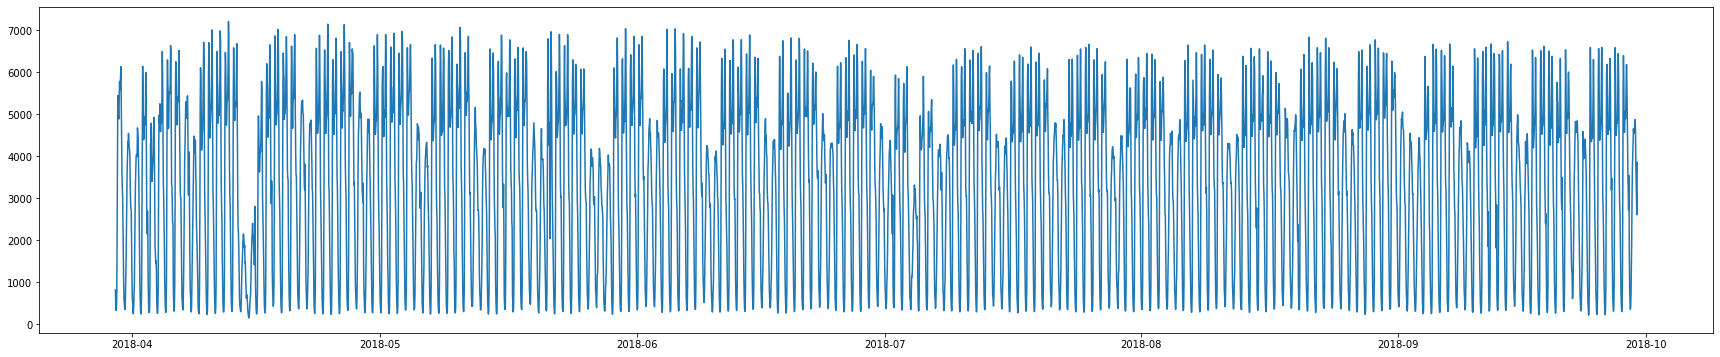

In [0]:
plt.figure(figsize=(30,6))
plt.plot(ts.traffic_volume)
plt.show()

Train/Test Split

In [0]:
#split_date = '2018-06-30'
split_date = '2018-08-30'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

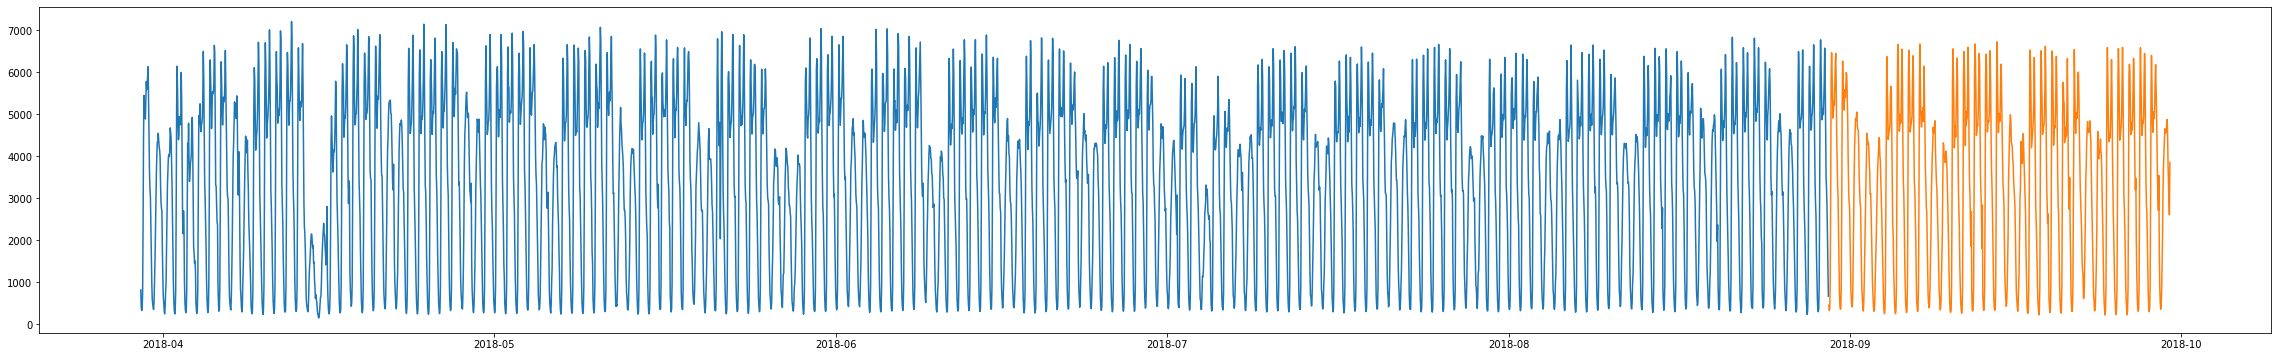

In [0]:
plt.figure(figsize=(40,6))
plt.plot(ts_train.traffic_volume)
plt.plot(ts_test.traffic_volume)
plt.show()

Simple Prophet Model

In [0]:
ts_train.reset_index(drop=True).rename(columns={'date_time':'ds', 'traffic_volume':'y'}).head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,y
0,None,272.30,0.0,0.0,1,Clear,sky is clear,2018-03-30 00:00:00,817
1,None,271.93,0.0,0.0,1,Clear,sky is clear,2018-03-30 01:00:00,413
2,None,271.22,0.0,0.0,1,Clear,sky is clear,2018-03-30 02:00:00,329
3,None,270.09,0.0,0.0,1,Clear,sky is clear,2018-03-30 03:00:00,359
4,None,269.65,0.0,0.0,1,Clear,sky is clear,2018-03-30 04:00:00,749


In [0]:
ts_train = ts_train.rename(columns={'date_time':'ds', 'traffic_volume':'y'})

In [0]:
# Setup and train model
model = Prophet()
model.fit(ts_train)
#model.fit(ts_train.reset_index().rename(columns={'date_time':'ds', 'traffic_volume':'y'}))

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


KeyError: ignored

In [0]:
# Predict on training set with model
ts_test_fcst = model.predict(df=ts_test.reset_index().rename(columns={'date_time':'ds'}))

NameError: ignored

In [0]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(ts_test_fcst, ax=ax)

NameError: ignored

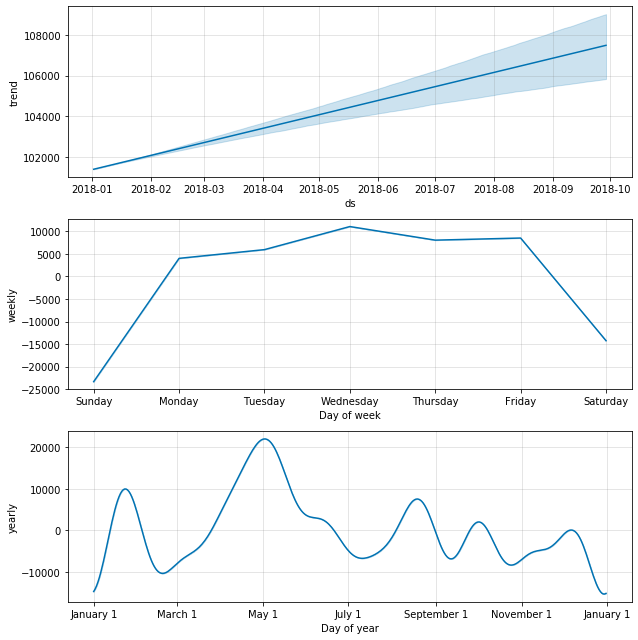

In [0]:
# Plot the components
fig = model.plot_components(ts_test_fcst)

**Compare Forecast to Actuals**

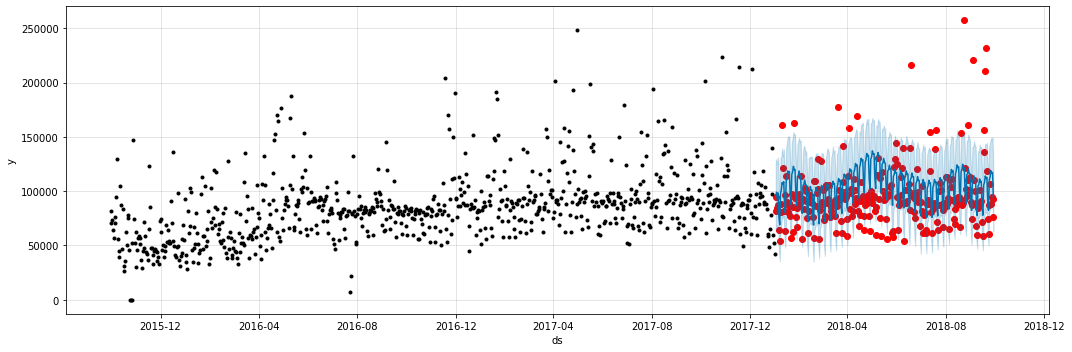

In [0]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test, color='r')
fig = model.plot(ts_test_fcst, ax=ax)

**Error Metrics**

In [0]:
mean_squared_error(y_true=ts_test,
                   y_pred=ts_test_fcst['yhat'])

827426715.1781645

In [0]:
mean_absolute_error(y_true=ts_test,
                   y_pred=ts_test_fcst['yhat'])

22713.386559219405

**Adding Regressor**

In [0]:
data_d

date_time
2012-10-02    63289
2012-10-03    66345
2012-10-04    89939
2012-10-05    93336
2012-10-06    74910
              ...  
2018-09-26    88627
2018-09-27    94434
2018-09-28    92518
2018-09-29    76242
2018-09-30    68785
Freq: D, Name: traffic_volume, Length: 2190, dtype: int64

In [0]:
# Create a dataframe with holiday, ds columns
#data_d = data.traffic_volume.resample("D", how='sum') 
ts2 = data['2017-09-30':'2018-09-29']

In [0]:
plt.figure(figsize=(15,6))
plt.plot(ts2['y'])
plt.show()

KeyError: ignored

<Figure size 1080x432 with 0 Axes>

In [0]:
ts2 = ts2.rename(columns={'date_time': 'ds', 'traffic_volume': 'y'})

In [0]:
# Split train/test
split_date = '2018-06-30'
ts_train = ts2.loc[ts2.index <= split_date].copy()
ts_test = ts2.loc[ts2.index > split_date].copy()

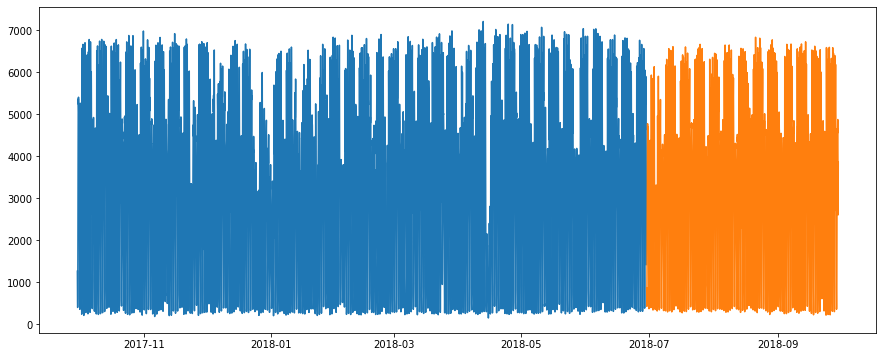

In [0]:
plt.figure(figsize=(15,6))
plt.plot(ts_train.y)
plt.plot(ts_test.y)
plt.show()

In [0]:
m = Prophet()
m.add_regressor('temp')
m.fit(ts_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [0]:
ts_test_fcst = m.predict(df=ts_test)

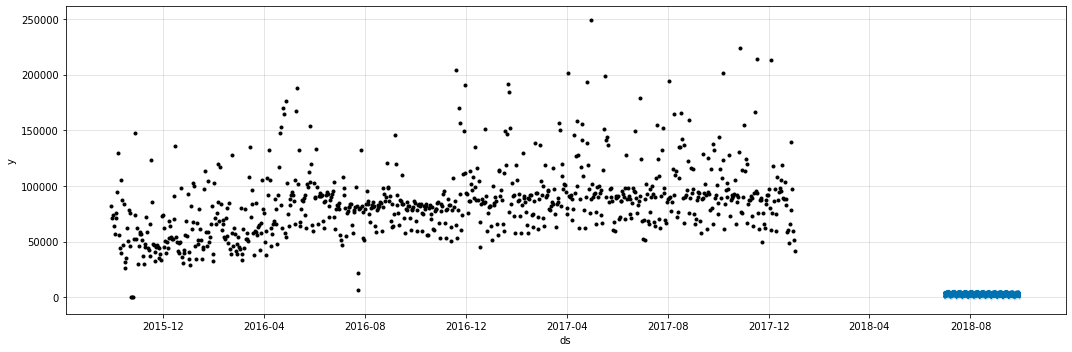

In [0]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(ts_test_fcst, ax=ax)

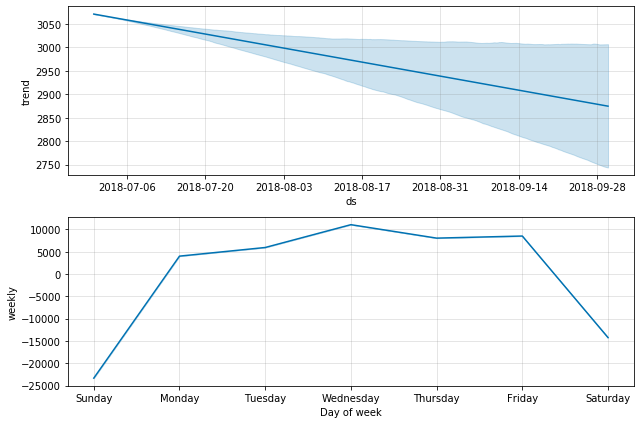

In [0]:
# Plot the components
fig = model.plot_components(ts_test_fcst)

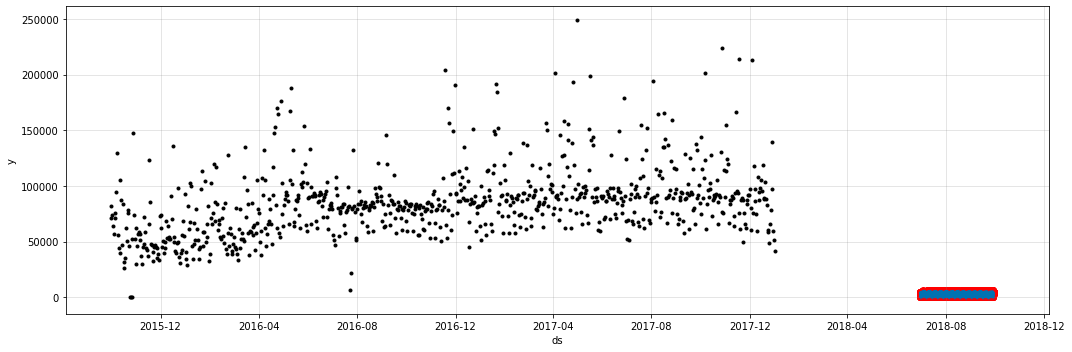

In [0]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test['y'], color='r')
fig = model.plot(ts_test_fcst, ax=ax)

In [0]:
ts_test_fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,temp,temp_lower,temp_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-06-30 01:00:00,3071.104843,-599.594736,1750.571956,3071.104843,3071.104843,-2495.195605,-2495.195605,-2495.195605,-2814.143043,-2814.143043,-2814.143043,377.505161,377.505161,377.505161,377.505161,377.505161,377.505161,-58.557722,-58.557722,-58.557722,0.0,0.0,0.0,575.909238
1,2018-06-30 02:00:00,3071.015789,-966.582793,1223.793744,3071.015789,3071.015789,-2958.701080,-2958.701080,-2958.701080,-3232.181250,-3232.181250,-3232.181250,377.072963,377.072963,377.072963,377.072963,377.072963,377.072963,-103.592793,-103.592793,-103.592793,0.0,0.0,0.0,112.314710
2,2018-06-30 03:00:00,3070.926736,-937.696060,1400.576459,3070.926736,3070.926736,-2803.611815,-2803.611815,-2803.611815,-3027.742303,-3027.742303,-3027.742303,373.327249,373.327249,373.327249,373.327249,373.327249,373.327249,-149.196760,-149.196760,-149.196760,0.0,0.0,0.0,267.314921
3,2018-06-30 03:00:00,3070.926736,-906.903915,1441.702003,3070.926736,3070.926736,-2803.611815,-2803.611815,-2803.611815,-3027.742303,-3027.742303,-3027.742303,373.327249,373.327249,373.327249,373.327249,373.327249,373.327249,-149.196760,-149.196760,-149.196760,0.0,0.0,0.0,267.314921
4,2018-06-30 04:00:00,3070.837682,-50.257804,2235.540047,3070.837682,3070.837682,-1954.068370,-1954.068370,-1954.068370,-2117.865374,-2117.865374,-2117.865374,358.920655,358.920655,358.920655,358.920655,358.920655,358.920655,-195.123651,-195.123651,-195.123651,0.0,0.0,0.0,1116.769312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,2018-09-29 19:00:00,2875.008702,1258.727802,3587.511424,2744.303652,3006.780671,-450.899395,-450.899395,-450.899395,243.360683,243.360683,243.360683,62.000755,62.000755,62.000755,62.000755,62.000755,62.000755,-756.260834,-756.260834,-756.260834,0.0,0.0,0.0,2424.109307
2741,2018-09-29 20:00:00,2874.919649,618.949156,2829.456973,2744.180161,3006.793226,-1195.084831,-1195.084831,-1195.084831,-479.461864,-479.461864,-479.461864,60.127898,60.127898,60.127898,60.127898,60.127898,60.127898,-775.750866,-775.750866,-775.750866,0.0,0.0,0.0,1679.834818
2742,2018-09-29 21:00:00,2874.830595,60.739604,2362.681929,2744.056671,3006.805782,-1675.870232,-1675.870232,-1675.870232,-941.622189,-941.622189,-941.622189,57.966909,57.966909,57.966909,57.966909,57.966909,57.966909,-792.214952,-792.214952,-792.214952,0.0,0.0,0.0,1198.960363
2743,2018-09-29 22:00:00,2874.741541,-296.377492,2032.426325,2743.933181,3006.818338,-1972.531725,-1972.531725,-1972.531725,-1226.909907,-1226.909907,-1226.909907,59.983832,59.983832,59.983832,59.983832,59.983832,59.983832,-805.605651,-805.605651,-805.605651,0.0,0.0,0.0,902.209816
